In [19]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openaq import OpenAQ
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Parameters
RADIUS = 10_000
LIMIT = 4
DATE_RANGE = [datetime.now() - timedelta(days=1), datetime.now()]

LOCATIONS_DICT = {
    "Canyon ES (2795)": 947312,
    "Pacific Palisades ES (5959)": 947232,
    "Revere MS (8356)": 947280,
    "Brentwood Sci Mag ES (2507)": 947305
}

In [3]:
# Put your OpenAQ API key in a text file with the name "openaq_api_key.txt"
with open("api_keys/openaq_api_key.txt", "r") as file:
    API_KEY = file.read()

# Initialize the OpenAQ client
client = OpenAQ(api_key=API_KEY)

In [4]:
# Function to fetch sensor data near a given location, return a dataframe where each row is a sensor and has data about the location and one column contains the measurements
def fetch_nearby_sensors(latitude, longitude, radius=10_000, limit=3):
    # Get the locations near the given coordinates
    response = client.locations.list(coordinates=(latitude, longitude), radius=radius, limit=limit)

    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for location in response.results:
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [9]:
def fetch_sensors_by_list(sensor_list):

    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for id in sensor_list:
        location = client.locations.get(id).results[0]
        print(f"""Fetching {location.name} data""")
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [10]:
# Example: Get sensors within 10km of Los Angeles (34.0549, -118.2426)
#df = fetch_nearby_sensors(latitude=34.03213, longitude=-118.51198, radius=RADIUS, limit=LIMIT)

# Get only the first location for time series analysis
df = fetch_sensors_by_list([list(LOCATIONS_DICT.values())[0]])

Fetching Canyon ES (2795) data


## Exploratory Data Analysis

In [11]:
# Display results
df.head()

,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units
1,1,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 01:54:32,0 days 00:03:00,pm1,1.42,µg/m³
2,2,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:00:15,0 days 00:03:00,pm1,0.22,µg/m³
3,3,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:05:59,0 days 00:03:00,pm1,0.00,µg/m³
4,4,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:11:42,0 days 00:03:00,pm1,0.00,µg/m³
5,5,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:17:26,0 days 00:03:00,pm1,0.38,µg/m³


In [12]:
# Basic Info
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 5000
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   measurement_id  5000 non-null   int64          
 1   sensor_id       5000 non-null   int64          
 2   location_id     5000 non-null   int64          
 3   location        5000 non-null   object         
 4   latitude        5000 non-null   float64        
 5   longitude       5000 non-null   float64        
 6   epoch           5000 non-null   datetime64[ns] 
 7   duration        5000 non-null   timedelta64[ns]
 8   parameter       5000 non-null   object         
 9   value           5000 non-null   float64        
 10  units           5000 non-null   object         
dtypes: datetime64[ns](1), float64(3), int64(3), object(3), timedelta64[ns](1)
memory usage: 468.8+ KB
None


In [13]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
measurement_id    0
sensor_id         0
location_id       0
location          0
latitude          0
longitude         0
epoch             0
duration          0
parameter         0
value             0
units             0
dtype: int64


In [14]:
# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       measurement_id     sensor_id  location_id    latitude     longitude  \
count     5000.000000  5.000000e+03       5000.0  5000.00000  5.000000e+03   
mean      2500.500000  3.298218e+06     947312.0    34.03213 -1.185120e+02   
min          1.000000  2.000855e+06     947312.0    34.03213 -1.185120e+02   
25%       1250.750000  2.000858e+06     947312.0    34.03213 -1.185120e+02   
50%       2500.500000  2.000861e+06     947312.0    34.03213 -1.185120e+02   
75%       3750.250000  5.244258e+06     947312.0    34.03213 -1.185120e+02   
max       5000.000000  5.244259e+06     947312.0    34.03213 -1.185120e+02   
std       1443.520003  1.589094e+06          0.0     0.00000  1.421228e-14   

                               epoch                   duration        value  
count                           5000                       5000  5000.000000  
mean   2022-08-31 19:18:15.748999936            0 days 00:03:48    13.509264  
min              2022-02-18 01:54:32   

In [15]:
# Show unique location ids in dataset

locations = df['location_id'].unique()
print("\nUnique Location IDs: ", locations)
print("Number of location ids:", len(locations))


Unique Location IDs:  [947312]
Number of location ids: 1


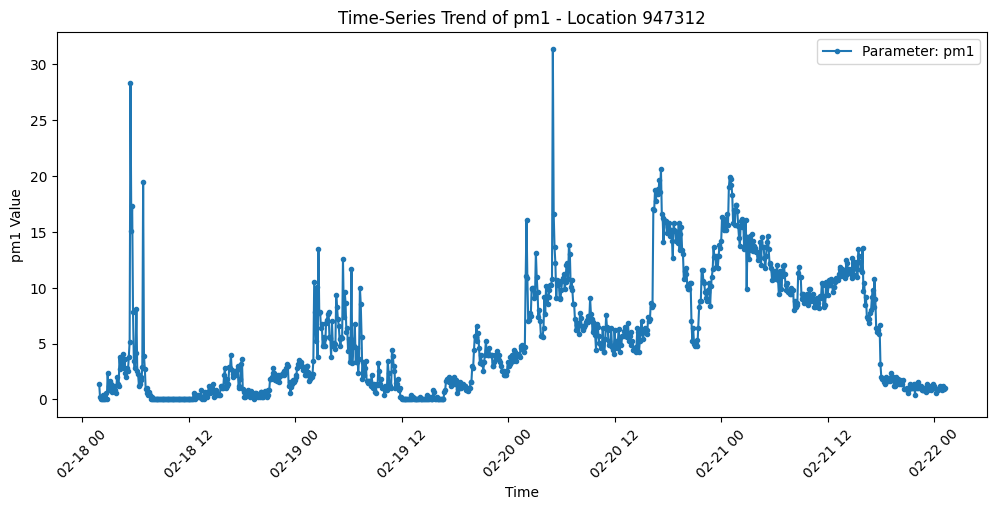

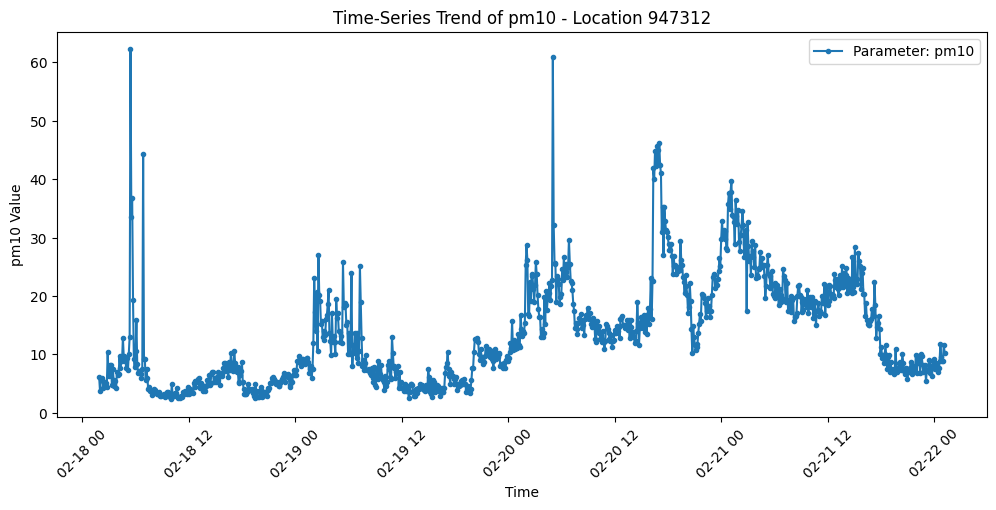

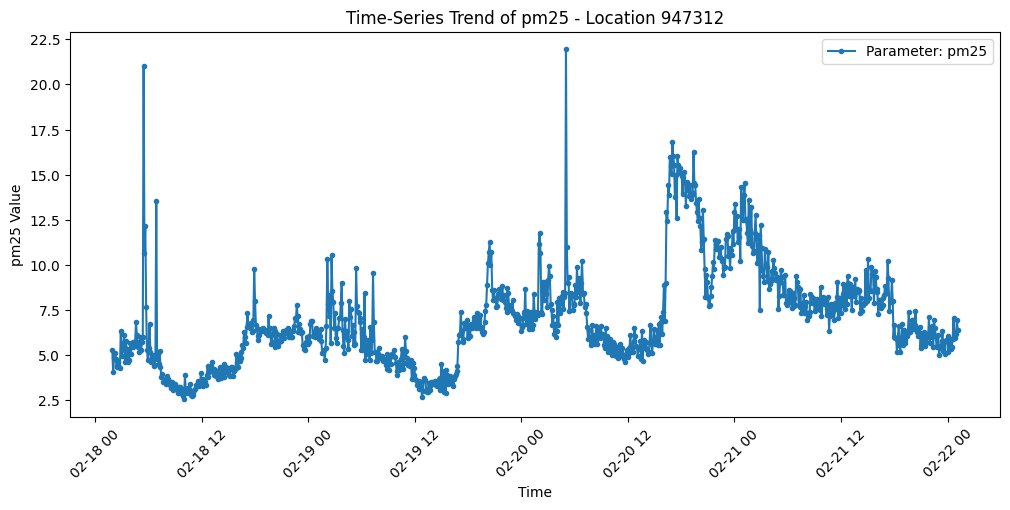

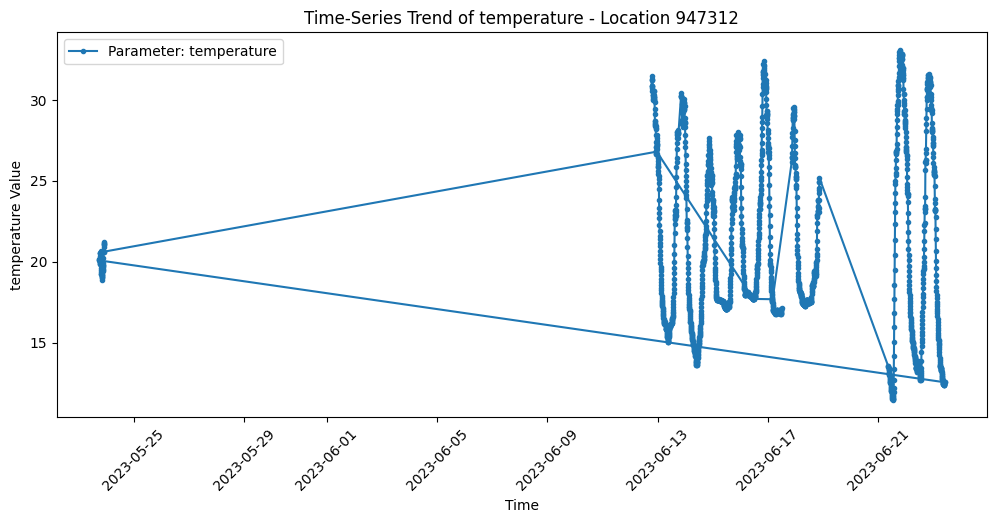

In [16]:
import matplotlib.pyplot as plt

# Loop through each unique location_id
for location in df['location_id'].unique():
    df_location = df[df['location_id'] == location]  # Filter data for this location
    
    # Loop through each unique parameter
    for parameter in df_location['parameter'].unique():
        df_param = df_location[df_location['parameter'] == parameter]  # Filter data for this parameter
        
        plt.figure(figsize=(12, 5))
        plt.plot(df_param['epoch'], df_param['value'], marker='o', linestyle='-', markersize=3, label=f"Parameter: {parameter}")
        plt.xlabel("Time")
        plt.ylabel(f"{parameter} Value")
        plt.title(f"Time-Series Trend of {parameter} - Location {location}")
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

### Review Spacing Between Data Points

['pm1' 'pm10' 'pm25' 'temperature']


/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_3755/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


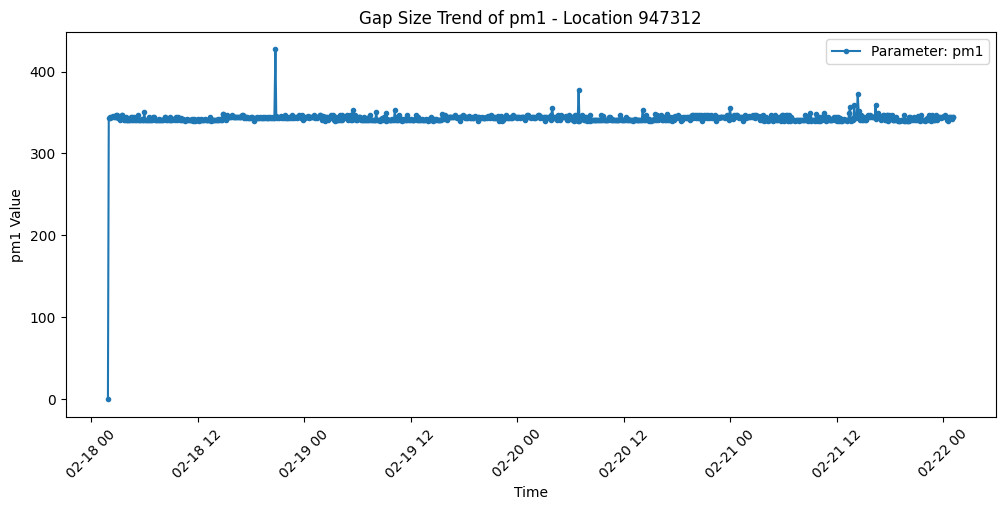

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_3755/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


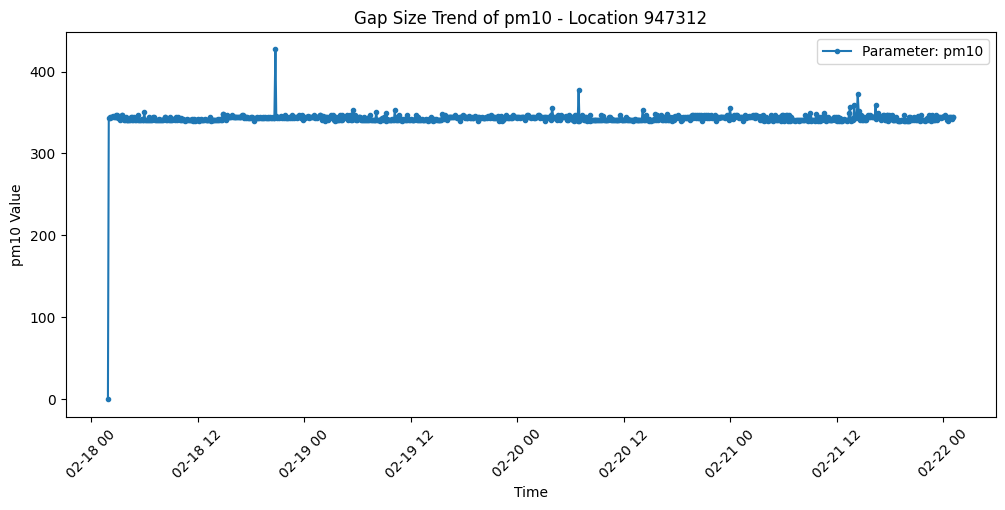

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_3755/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


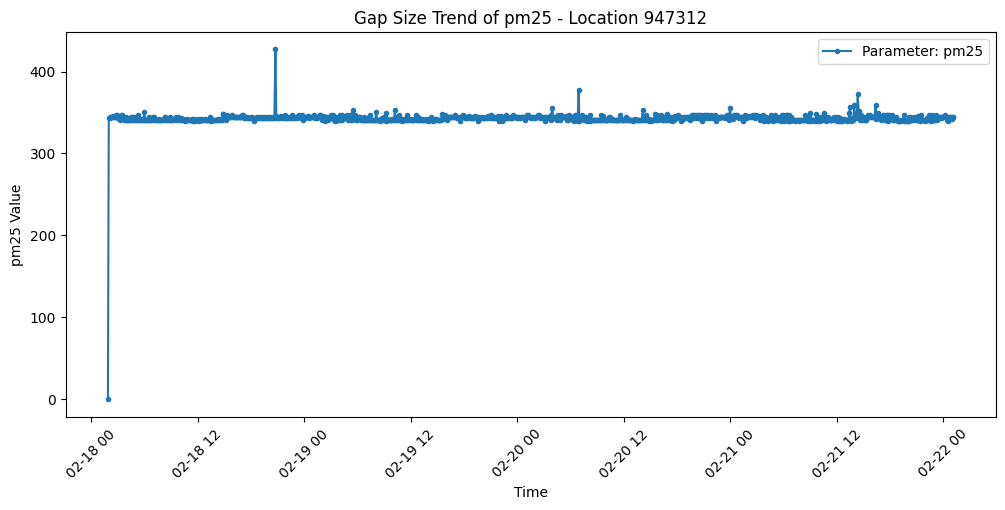

/var/folders/v3/6g8j12qj0yd6zlbh6nr578p80000gn/T/ipykernel_3755/1850392205.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)


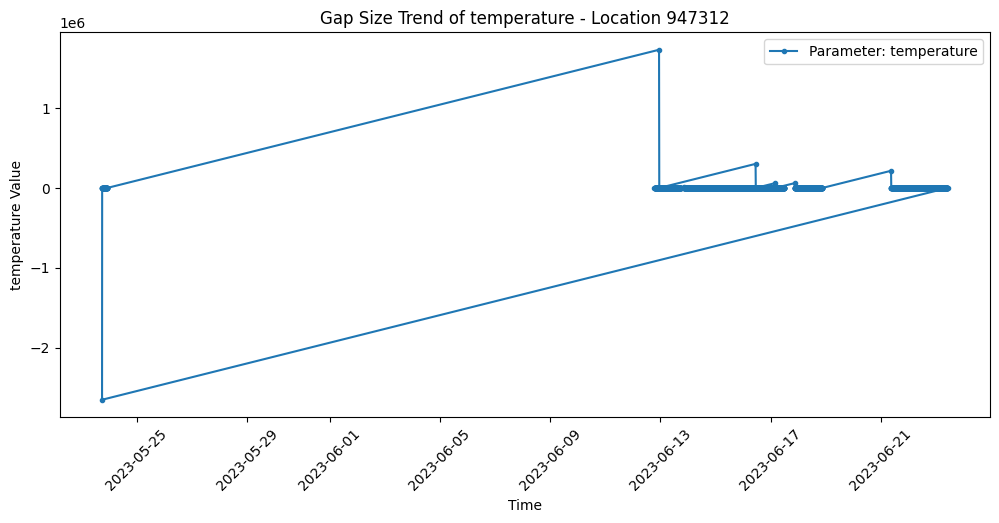

In [17]:
location_id = 947312

df_location = df[df['location_id'] == location_id]  # Filter data for this location

print(df_location['parameter'].unique())

for parameter in df_location['parameter'].unique():
    df_param = df_location[df_location['parameter'] == parameter]  # Filter data for this parameter

    df_param["gap_size"] = df_param["epoch"].diff().dt.total_seconds().fillna(0)

    plt.figure(figsize=(12, 5))
    plt.plot(df_param['epoch'], df_param['gap_size'], marker='o', linestyle='-', markersize=3, label=f"Parameter: {parameter}")
    plt.xlabel("Time")
    plt.ylabel(f"{parameter} Value")
    plt.title(f"Gap Size Trend of {parameter} - Location {location_id}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

## Part 2: Time Series Modeling

Split Data

In [116]:
TRAIN_SPLIT = 0.4
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
PROD_SPLIT = 0.4

SEQ_LEN = 20
PRED_LEN = 1

In [117]:
# Split training
train_data = df_location.iloc[:int(len(df_location) * TRAIN_SPLIT)]
train_data = train_data.reset_index(drop=True)

# Split validation
val_data = df_location.iloc[int(len(df_location) * TRAIN_SPLIT):int(len(df_location) * TRAIN_SPLIT) + int(len(df_location) * VAL_SPLIT)]
val_data = val_data.reset_index(drop=True)

# Split testing
test_data = df_location.iloc[int(len(df_location) * TRAIN_SPLIT) + int(len(df_location) * VAL_SPLIT):int(len(df_location) * TRAIN_SPLIT) + int(len(df_location) * VAL_SPLIT) + int(len(df_location) * TEST_SPLIT)]
test_data = test_data.reset_index(drop=True)

# Split production
prod_data = df_location.iloc[int(len(df_location) * TRAIN_SPLIT) + int(len(df_location) * VAL_SPLIT) + int(len(df_location) * TEST_SPLIT):]
prod_data = prod_data.reset_index(drop=True)

In [118]:
# Normalize the training dataset
scaler = StandardScaler()
train_data.loc[:, "value"] = scaler.fit_transform(train_data["value"].values.reshape(-1, 1))
val_data.loc[:, "value"] = scaler.transform(val_data["value"].values.reshape(-1, 1))
test_data.loc[:, "value"] = scaler.transform(test_data["value"].values.reshape(-1, 1))

In [119]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=30, pred_len=1):
        """
        Args:
        - data (pd.DataFrame or np.array): Time series values
        - seq_len (int): Number of time steps in input sequence
        - pred_len (int): Number of time steps in output sequence
        """
        self.data = np.array(data["value"]) if isinstance(data, pd.DataFrame) else np.array(data) 
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        """Returns total number of sequences available"""
        return max(0, len(self.data) - self.seq_len - self.pred_len) 

    def __getitem__(self, idx):
        """Retrieves input sequence and target sequence"""
        if idx >= len(self):  
            raise IndexError(f"Index {idx} out of bounds for dataset length {len(self)}")

        x = self.data[idx : idx + self.seq_len]
        y = self.data[idx + self.seq_len : idx + self.seq_len + self.pred_len]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [120]:
print(len(train_data))

2000


In [121]:
# Create DataLoaders
BATCH_SIZE = 8

train_dataset = TimeSeriesDataset(train_data, seq_len=SEQ_LEN, pred_len=PRED_LEN)
val_dataset = TimeSeriesDataset(val_data, seq_len=SEQ_LEN, pred_len=PRED_LEN)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [123]:
# Define a function to build sequences

def build_sequences(data, seq_len=SEQ_LEN, pred_len=PRED_LEN):
    X, y = [], []

    for i in range(len(data) - seq_len - pred_len):
        X.append(data["value"].values[i:i + seq_len])
        y.append(data["value"].values[i + seq_len:i + seq_len + pred_len])

    return np.array(X), np.array(y)

### Define Model

In [124]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))
        return self.fc(out[:, -1, :])

In [125]:
model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [126]:
print(train_loader)

In [127]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/10, Train Loss: 0.1597, Val Loss: 0.0452
Epoch 2/10, Train Loss: 0.1316, Val Loss: 0.0293
Epoch 3/10, Train Loss: 0.1271, Val Loss: 0.0067
Epoch 4/10, Train Loss: 0.1264, Val Loss: 0.0521
Epoch 5/10, Train Loss: 0.1261, Val Loss: 0.0026
Epoch 6/10, Train Loss: 0.1244, Val Loss: 0.0006
Epoch 7/10, Train Loss: 0.1226, Val Loss: 0.0019
Epoch 8/10, Train Loss: 0.1212, Val Loss: 0.0038
Epoch 9/10, Train Loss: 0.1228, Val Loss: 0.0001
Epoch 10/10, Train Loss: 0.1156, Val Loss: 0.0006


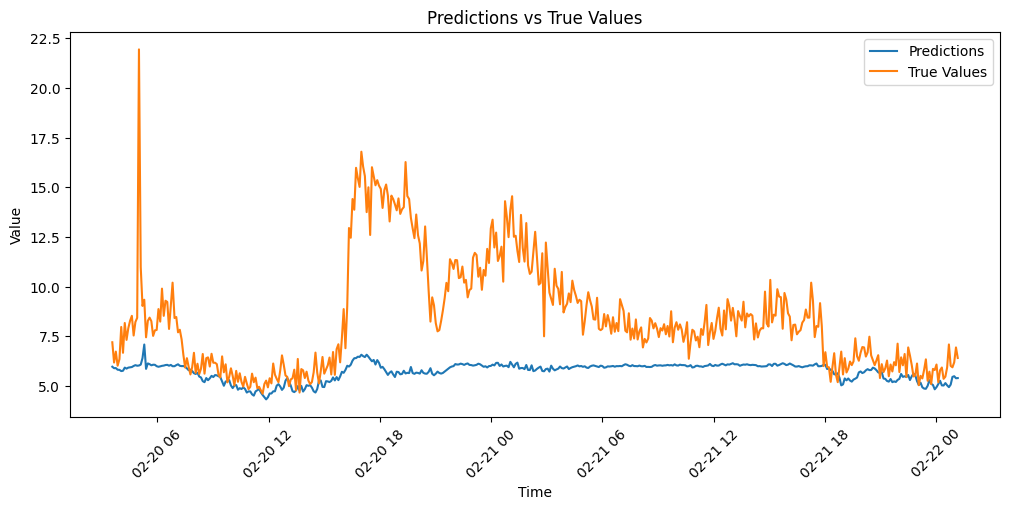

In [128]:
# Generate predictions
model.eval()
test_inputs = torch.from_numpy(test_input).float()
test_outputs = model(test_inputs)

# Inverse transform the predictions
test_outputs = scaler.inverse_transform(test_outputs.detach().numpy())

# Plot the predictions
plt.figure(figsize=(12, 5))
plt.plot(test_data["epoch"].values[SEQ_LEN + PRED_LEN:], test_outputs, label="Predictions")
plt.plot(test_data["epoch"].values[SEQ_LEN + PRED_LEN:], test_data["value"].values[SEQ_LEN + PRED_LEN:], label="True Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predictions vs True Values")
plt.xticks(rotation=45)
plt.legend()
plt.show()